# TKC: Airborne Time Domain Electromagnetics

In this example, we perform a forward simulation and inversion over a synthetic model of the Tli Kwi Cho Kimberlite Complex in Northern Canada. 

In [1]:
import numpy as np
from scipy.constants import mu_0
import matplotlib.pyplot as plt
import ipywidgets

from SimPEG import EM, Mesh, Utils, Maps

%matplotlib inline

In [2]:
# import a solver. If you want to re-run the forward simulation or inversion, 
# make sure you have pymatsolver (https://github.com/rowanc1/pymatsolver) 
# installed. The default solverLU will be painfully slow. 

try:
    from pymatsolver import Pardiso as Solver
except Exception:
    from SimPEG import SolverLU as Solver
    print(
        'Using the default solver. Install pymatsolver '
        'if you want to re-run the forward simulation or inversion'
    )

## Download synthetic model

The vtk surfaces defining the model are stored on the cloud, so first, we download those to a local directory. 

In [3]:
download_dir = './TKC_ATEM/'  # name of the local directory to create and put the files in. 

root_url = 'https://storage.googleapis.com/simpeg/tkc_synthetic/atem/' 
files = ['VTKout.dat']
urls = [root_url + f for f in files]

downloads = Utils.download(url=urls, folder=download_dir, overwrite=True)
downloads = dict(zip(['sigma_model'], downloads))  # create a dict

overwriting VTKout.dat
Download completed!


## Mesh

We define a Tensor Mesh that will be used for the forward simulation and eventually the inversion.

In [4]:
cs, npad = 35., 13
ncx, ncy = 19, 15
nczd, nczu, nczm = 9, 9, 6
hx = [(cs,npad, -1.3),(cs,ncx),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,ncy),(cs,npad, 1.3)]
hz = [(cs,npad, -1.3),(cs,nczd), (cs/2,nczm) ,(cs,nczu),(cs,npad, 1.3)]
mesh = Mesh.TensorMesh([hx, hy, hz], x0="CCC")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.

print(mesh)

  ---- 3-D TensorMesh ----  
   x0: -4774.44
   y0: -4704.44
   z0: -4809.44
  nCx: 45
  nCy: 41
  nCz: 50
   hx: 1060.06,  815.43,  627.26,  482.50,  371.16,  285.51,  219.62,  168.94,  129.95,  99.96,  76.89,  59.15,  45.50,  19*35.00,  45.50,  59.15,  76.89,  99.96,  129.95,  168.94,  219.62,  285.51,  371.16,  482.50,  627.26,  815.43,  1060.06,
   hy: 1060.06,  815.43,  627.26,  482.50,  371.16,  285.51,  219.62,  168.94,  129.95,  99.96,  76.89,  59.15,  45.50,  15*35.00,  45.50,  59.15,  76.89,  99.96,  129.95,  168.94,  219.62,  285.51,  371.16,  482.50,  627.26,  815.43,  1060.06,
   hz: 1060.06,  815.43,  627.26,  482.50,  371.16,  285.51,  219.62,  168.94,  129.95,  99.96,  76.89,  59.15,  45.50,  9*35.00,  6*17.50,  9*35.00,  45.50,  59.15,  76.89,  99.96,  129.95,  168.94,  219.62,  285.51,  371.16,  482.50,  627.26,  815.43,  1060.06,


## Plot the model on the mesh

The model has been generated from drilling results over TKC. From the vtk surfaces, we then define the model on a cartesian mesh. That is the model that is provided here. We will plot the model.

In [5]:
sigma = mesh.readModelUBC(downloads["sigma_model"])

To view the model, we generate two simple plotting functions that can be re-used later. The first plots a cross section through the model, the second plots a plan-view (depth slice). 

In [6]:
# functions for visualizing the model 
def vizsection(sigma, indy=20, ax=None):
    """
    Plot a cross section of the conductivity model
    """
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize = (5,2.5))
    mesh.plotSlice(
        np.log10(sigma), ind=indy, grid=True, normal="Y", clim=(-4, -1), ax=ax
    )
    ax.axis("equal")
    ax.set_title(("Northing at %.1fm")%(mesh.vectorCCy[indy]))
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")    
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 0)
    
def vizplan(sigma, indz=21, ax=None):
    """
    Plot a plan view of the conductivity model
    """
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize = (5,5))
    mesh.plotSlice(np.log10(sigma), grid=True, ind=indz, clim=(-4, -1), ax=ax)
    ax.set_title(("Elevation at %.1fm")%(mesh.vectorCCz[indz]))
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)

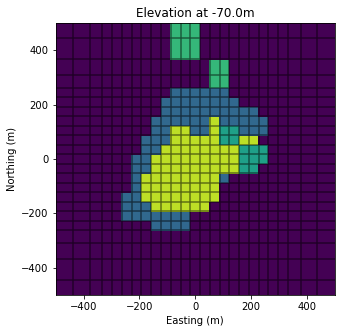

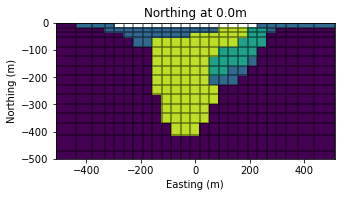

In [7]:
# for plotting, we will turn the air indices to nan's 
sigma_masked = sigma.copy()

airind = (sigma==1e-8)
sigma_masked[airind] = np.nan

vizplan(sigma_masked)
vizsection(sigma_masked)

While we are working with the conductivity model, it is handy to know where topography is (later on in the inversion, we will use this to define an active cell model). 

In [8]:
def gettopoCC(mesh, airind):
    """
    Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC

## Survey
Now that we have the conductivity model defined, we turn our attention to defining a survey. We start by defining the sounding locations. We take the src / rx height to be z=30m

In [9]:
# easting
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-250., mesh.vectorCCx<250.)]

# northing - use slightly wider spacing
nskip = 2
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-250., mesh.vectorCCy<250.)][::nskip]

# height
z = np.r_[30.]

# grid of locations
xyz = Utils.ndgrid(x, y, z)

Here, we plot the projection of the sounding locations on a depth slice through the model. 

(-400, 400)

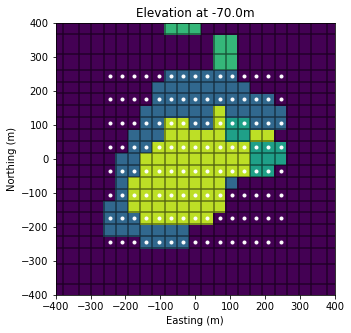

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
vizplan(sigma_masked, ax=ax)
ax.plot(xyz[:,0], xyz[:,1], 'wo', ms=3)
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)

Next we create the survey object, for an airborne survey, each source has a single receiver. Here we measure the vertical magnetic field as data and use a step-off waveform for source.  

In [11]:
ntx = xyz.shape[0]
srcList = []
times = np.logspace(-4, np.log10(2e-3), 10)

for itx in range(ntx):
    rx = EM.TDEM.Rx.Point_b(xyz[itx,:], times, orientation='z')
    src = EM.TDEM.Src.CircularLoop(
        [rx], waveform=EM.TDEM.Src.StepOffWaveform(), 
        loc=xyz[itx,:], radius=13.
    )       
    srcList.append(src)
    
print(
    'In this survey, there are {nsrc} soundings'.format(
        nsrc=len(srcList)
    )
)
print(
    'There are {ntimes} time channels, '
    'and we are sampling the {comp}-component '
    'of the {field}-field'.format(
        ntimes = len(times),
        comp=rx.projComp,
        field=rx.projField
    )
)

In this survey, there are 120 soundings
There are 10 time channels, and we are sampling the z-component of the b-field


## Forward Simulation

In [12]:
# setup and run the forward simulation 
timeSteps_fwd = [(1e-5, 5), (1e-4, 10),(5e-4, 10)]

survey = EM.TDEM.Survey(srcList)    
problem = EM.TDEM.Problem3D_b(
    mesh, timeSteps=timeSteps_fwd, verbose=False, 
    sigmaMap=Maps.IdentityMap(mesh)
)
problem.pair(survey)
problem.Solver = Solver

If you have modest compute resources (and a little patience!), uncomment the next line and you can run the simulation. There is also a script  you can download (see: TODO) if you have access to a cluster where SimPEG is installed (see for instructions on installing SimPEG) and run the simulation. 

In [13]:
# %timeit
# dpred = survey.dpred(sigma)
# TKCATEMexample = {
#     "mesh": mesh, "sigma": sigma, "xyz": xyz, "ntx": tx,
#     "times": times, "timeSteps": problem.timeSteps, "dpred": dpred
# }
# pickle.dump(
#     TKCATEMexample, open(download_dir + "/TKCATEMfwd.p", "wb" )
# )